# Project Machine Learning: Group 25
### Peter Bonnarens, Lennert Franssens & Philip Kukoba

# Sprint 1 : Tabular Data

### Possible tasks:
* Thorough exploratory data analysis, e.g.:
    * Are there substantial price differences between neighbourhoods ?
    * Are there hosts with more than one listing ? How does this impact the price ?
    * What is the correlation between the review score and the price ?
    * ...

    Not enough to just show a plot! Clearly describe WHAT question you investigated, WHY you think this is a relevant question
    and WHAT you deduce/conclude from the results of your data analysis

* Are there outliers ?
* A new Airbnb owner needs to pick an appropriate price:
    * Train a model to predict the price based on a selection of features
    * Find the most similar listings
    
* ...

# Table of work (who did what)

| X | Task 1 | Task 2 | Task 3 |
| --- | --- | --- | --- |
| Peter Bonnarens | | X | X |
| Lennert Franssens | X | | X |
| Philip Kukoba | X | X | |

# Reading the dataset

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns 
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 20,16

%matplotlib inline

In [14]:
listings = pd.read_csv("data/listings.csv")
print(listings["accommodates"].unique())
listings = listings[["id", "name", "host_id", "host_response_time", "host_response_rate", "host_acceptance_rate", "host_total_listings_count", "host_verifications", "host_has_profile_pic","host_identity_verified", "neighbourhood_cleansed", "room_type", "accommodates", "price", "minimum_nights", "minimum_nights", "maximum_nights", "minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights", "minimum_nights_avg_ntm", "maximum_nights_avg_ntm", "number_of_reviews", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value"]]

# host_is_superhost t->1 en f->0
# convert price to float

listings.head()


,id,host_since,host_location,host_response_time,host_response_rate,host_listings_count,price,minimum_nights,minimum_nights,maximum_nights,...,maximum_nights_avg_ntm,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license
0,187870,2011-08-01,"Ghent, Flanders, Belgium",within an hour,100%,2.0,$65.00,2,2,90,...,1125.0,419,4.85,4.90,4.95,4.90,4.87,4.58,4.85,NaN
1,203806,2011-08-21,PA,within an hour,100%,3.0,$79.00,2,2,1125,...,1125.0,287,4.59,4.72,4.73,4.80,4.79,4.49,4.54,NaN
2,204245,2011-08-22,"Gent, Vlaams Gewest, Belgium",within a day,100%,2.0,$93.00,1,1,14,...,14.0,30,4.79,4.73,4.93,4.83,4.70,4.97,4.63,NaN
3,216715,2011-08-02,"Ghent, Flemish Region, Belgium",within an hour,100%,1.0,$80.00,2,2,365,...,1125.0,474,4.75,4.81,4.90,4.89,4.85,4.89,4.76,NaN
4,252269,2011-09-22,"Ghent, Flemish Region, Belgium",within a few hours,100%,1.0,$235.00,2,2,120,...,120.0,154,4.89,4.92,4.93,4.92,4.97,4.98,4.72,NaN


### MERK OP: er zijn een paar rijen verschoven (bepaalde kolom die weg is ofzo): shift deze rijen!!!

1. host_response_time en host_response_rate: regex om tijdsinterval te kennen, slechte waarden van host_response_time vervangen door juiste waarde in host_response_rate (zie print(listings[ (~listings["host_response_rate"].isnull()) & (~listings["host_response_rate"].str.match('.*%', na=False)) ]) ) en percentage teken bij host_response_rate wegdoen
2. host acceptance rate: % wegdoen en omzetten naar float.
3. host total listings count: omzetten naar float
4. host verifications: omzetten naar lengte van de array om te kijken op hoeveel manieren een host kan geverifieerd worden (meer trustworthy?)
5. host has profile pic: omzetten naar 0 of 1 (misschien meer geboekt als wel profile pic?)
6. host identity verified: omzetten naar 0 of 1 (miscchien meer geboekt als verified?)
7.

<AxesSubplot:>

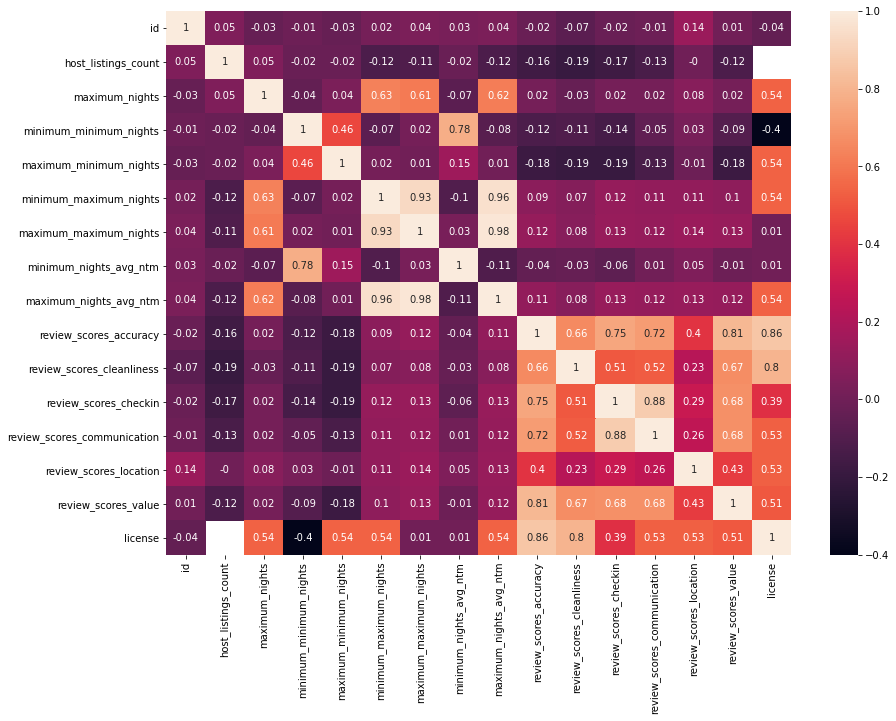

In [15]:
correlation_matrix = listings.corr().round(2)
plt.figure(figsize=(14,10))
sns.heatmap(data=correlation_matrix, annot=True)